In [1]:
!python3 -m grpc_tools.protoc -I /opt/proto --python_out=. --pyi_out=. --grpc_python_out=. /opt/proto/game.proto

In [2]:
!python3 -m pip install numpy==1.23.5
!python3 -m pip install pygad


In [3]:
import game_pb2_grpc
import game_pb2
import grpc
from subprocess import Popen, PIPE
import time
import traceback

In [4]:
def start_server(port, seed, filename):
    p = Popen(['xvfb-run', '--server-num' , str(port), r'./artifical_bike_racing', '--port', str(port), '--seed', str(seed), '--headless', '--save', f'/opt/clients/{filename}.json' ], stdout=PIPE, cwd=r'/opt/')
    broken = True
    while broken:
        try:
            channel = grpc.insecure_channel(f'localhost:{port}')
            stub = game_pb2_grpc.MainServiceStub(channel)
            stub.health(game_pb2.Empty())
            broken = False
        except:
            pass
        
    return stub, p.stdout

In [5]:
def kill_server(stub):
    stub.kill(game_pb2.Empty())
    try:
        stub.input(game_pb2.InputRequest(x = 0.0, z = 1.0))
        stub.getState(game_pb2.Empty())
        broken = True
        while broken:
            try:
                stub.health(game_pb2.Empty())
            except:
                broken = False
    except:
        pass

In [6]:
def get_score(stub):
    score = stub.getScore(game_pb2.Empty())
    try:
        stub.input(game_pb2.InputRequest(x = 0.0, z = 1.0))
        stub.getState(game_pb2.Empty())
        broken = True
        while broken:
            try:
                stub.health(game_pb2.Empty())
            except:
                broken = False
    except:
        pass
    return score

In [7]:
import pygad
import pygad.nn
import pygad.gann
import numpy as np

In [8]:
# retrieve the terrain at a given offset from the player, x = 0, z = 0 returns the terrain below the player
def terrain_at(terrain, x, z):
    if x < -32 or x > 32 or z < -32 or z > 32:
        return None
    x = x + 32
    z = z + 32
    terrain[x + z * 65]

In [9]:
# runs the game for {steps} frames for {seed}
# it uses the neural network behind the last_layer parameter
# the recording is stored under /opt/clients/{filename}.json and can be replayed as described in the readme
def play_game(port, seed, filename, last_layer, steps):
    stub, process = start_server(port, seed, filename)
    stub.input(game_pb2.InputRequest(x = 0.0, z = 1.0))
    state = stub.getState(game_pb2.Empty())
    for _ in range(steps):
        d = []
        if state.finished:
            return stub, state
        if state.y < -50:
            return stub, state
        d.append(state.x)
        d.append(state.y)
        d.append(state.z)
        d.append(state.distance)

        data_inputs = np.array([d])
        predictions =  pygad.nn.predict(last_layer=last_layer,
                                   data_inputs=data_inputs,  problem_type="regression")
        stub.input(game_pb2.InputRequest(x = predictions[0][0], z = predictions[0][1]))
        state = stub.getState(game_pb2.Empty())
    return stub, state

In [10]:
def fitness_func(solution, sol_idx):
    global GANN_instance
    if sol_idx is None:
        print("no index")
        return 0.0
    try:
        stub, state = play_game(50051 + sol_idx, 2, sol_idx, GANN_instance.population_networks[sol_idx], 1000)
        score = get_score(stub)
        del stub
        s = (float(len(score.timings)) + 1.0 / state.distance +(1000 - score.timings[-1])/2000.0)
        return s
    except Exception as e:
        print("--------------------")
        print(e)
        raise e
        

In [11]:
def callback_generation(ga_instance):
    global GANN_instance, last_fitness
    population_matrices = pygad.gann.population_as_matrices(population_networks=GANN_instance.population_networks,
                                                            population_vectors=ga_instance.population)

    GANN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))

    last_fitness = ga_instance.best_solution()[1].copy()

In [12]:
GANN_instance = pygad.gann.GANN(num_solutions=2,
                                num_neurons_input=4,
                                num_neurons_hidden_layers=[10],
                                num_neurons_output=2,
                                hidden_activations=["relu"],
                                output_activation="None")
last_fitness = 0
parent_selection_type = "rank"

crossover_type = "Single_point"

mutation_type = "random" 

keep_parents = 1

init_range_low = -10
init_range_high = 10
ga_instance = pygad.GA(num_generations=5, 
                       num_parents_mating=2, 
                       initial_population= pygad.gann.population_as_vectors(population_networks=GANN_instance.population_networks),
                       fitness_func=fitness_func,
                       mutation_percent_genes=20,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       on_generation=callback_generation,
                       parallel_processing=['process', 4])
ga_instance.run()


Generation = 1
Fitness    = 1.5595393245214886
Change     = 1.5595393245214886
Generation = 2
Fitness    = 1.5115405912679216
Change     = -0.04799873325356696
Generation = 3
Fitness    = 1.5595393245214886
Change     = 0.04799873325356696
Generation = 4
Fitness    = 1.5595393245214886
Change     = 0.0
Generation = 5
Fitness    = 1.5595393245214886
Change     = 0.0


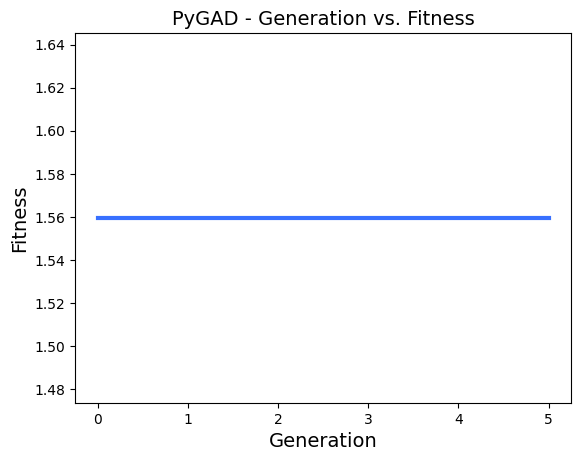

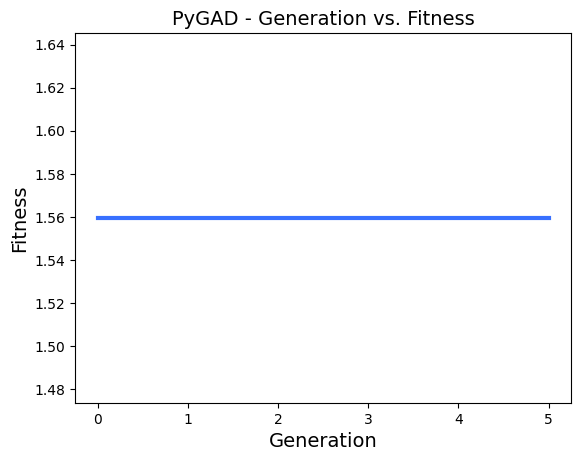

In [13]:
ga_instance.plot_fitness()

In [14]:
best_solution = ga_instance.best_solution()
stub, state = play_game(50051, 2, 'best', GANN_instance.population_networks[best_solution[2]], 10000 )